# Conductance synapse decoding demo

In this demo I establish a communication channel between two rate-based neuron populations with conductance based synapses.

In [66]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import scipy.interpolate

import nengo_conductance_synapses.lif_cond_utils as lif_cond_utils

import seaborn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's find the neuron parameters $a$, $b$, $c$, $d$ for a neuron population with $100$ neurons, maximum firing rate in the range between $50$ and $100$ and an $x$-intercept distribution between $-0.95$ and $0.95$ and plot the corresponding tuning curves.

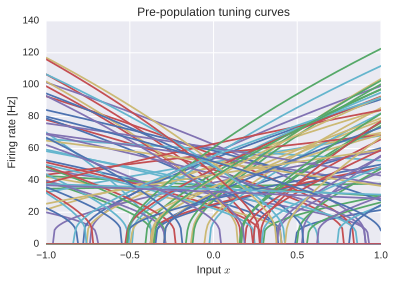

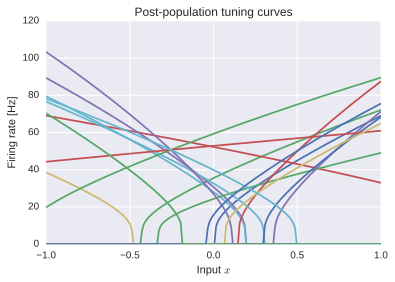

In [176]:
%autoreload

gL = 50 # ==> tau_rc = 20e-3
tau_ref = 2e-3
e_rev_E = 4.33
e_rev_I = -0.33

N_pre = 100
N_post = 20

def mksplines(N):
    def mkspline():
        poles = np.random.randint(1) * 2 + 3
        gEs = np.random.uniform(10, 50, poles)
        gIs = np.random.uniform(0.5 * np.min(gEs), 0.25 * np.max(gEs), poles)
        x = np.linspace(-1, 1, poles) + np.random.uniform(-0.5, 0.5) / poles
        y = np.array([gEs, gIs]).T
        return scipy.interpolate.make_interp_spline(x, y, k = 2)
    splines = [mkspline() for _ in range(N)]
    return lambda xs: np.array(list(map(lambda f: f(xs), splines))).T

def mkrlus(N):
    def mkrlu():
        gain = np.random.uniform(-100, 100)
        bias = np.random.uniform(0, 100)
        return lambda xs: np.clip(gain * xs + bias, 0, None)

    rlus = [mkrlu() for _ in range(N)]
    return lambda xs: np.array(list(map(lambda f: f(xs), rlus))).T

#splines_pre = mksplines(N_pre)
#splines_post = mksplines(N_post)
rlus_pre = mkrlus(N_pre)
rlus_post = mkrlus(N_post)

xs = np.linspace(-1, 1, 200)
#gE_pre_xs, gI_pre_xs = splines_pre(xs)
#gE_post_xs, gI_post_xs = splines_post(xs)
Js_pre_xs = rlus_pre(xs)
Js_post_xs = rlus_post(xs)

#activities_pre_xs = lif_cond_utils.lif_cond_rate(gL, gE_pre_xs, gI_pre_xs, e_rev_E, e_rev_I, tau_ref)
#activities_post_xs = lif_cond_utils.lif_cond_rate(gL, gE_post_xs, gI_post_xs, e_rev_E, e_rev_I, tau_ref)
activities_pre_xs = lif_cond_utils.lif_rate(gL, Js_pre_xs, tau_ref)
activities_post_xs = lif_cond_utils.lif_rate(gL, Js_post_xs, tau_ref)

fig, ax = plt.subplots()
ax.plot(xs, activities_pre_xs);
ax.set_title('Pre-population tuning curves')
ax.set_xlabel('Input $x$')
ax.set_ylabel('Firing rate [Hz]');

fig, ax = plt.subplots()
ax.plot(xs, activities_post_xs);
ax.set_title('Post-population tuning curves')
ax.set_xlabel('Input $x$')
ax.set_ylabel('Firing rate [Hz]');

Now let's solve for the weight matrices $W^+$ and $W^-$. Plot the linear functions $g_E$ and $g_I$ that are being decoded from the pre-population for each neuron in the post-population.

In [ ]:
%autoreload

ys = np.cos(np.pi * 2 * xs)

#gE_post_ys_tar, gI_post_ys_tar = splines_post(ys)
#activities_post_ys_tar = lif_cond_utils.lif_cond_rate(gL, gE_post_ys_tar, gI_post_ys_tar, e_rev_E, e_rev_I, tau_ref)

Js_post_ys_tar = rlus_post(ys)
activities_post_ys_tar = lif_cond_utils.lif_rate(gL, Js_post_ys_tar, tau_ref)

# Solve for the connection weights between the pre and post
# population
WE, WI = lif_cond_utils.solve_weight_matrices_for_activities(
    activities_pre_xs, activities_post_ys_tar,
    gL, e_rev_E, e_rev_I, tau_ref,
    reg=1e-1, lambda_=0.5, atol=1e-3)

# Fetch gE and gI
gE = activities_pre_xs @ WE
gI = activities_pre_xs @ WI

In [ ]:
# Plot the decoded functions for gE
fig, ax = plt.subplots()
ax.plot(xs, gE[:, 0:10], color='blue');

# Plot the decoded functions for gI
fig, ax = plt.subplots()
ax.plot(xs, gI[:, 0:10], color='red');

Now let's plot the tuning curves of the post-population depending on the input to the pre-population.

In [ ]:
activities_post_ys = lif_cond_utils.lif_cond_rate(gL, gE, gI, e_rev_E, e_rev_I, tau_ref)
fig, ax = plt.subplots()
ax.plot(xs, activities_post_ys_tar, linestyle='--', color='k', linewidth=0.5);
ax.plot(xs, activities_post_ys);

Decode the output of the post population.

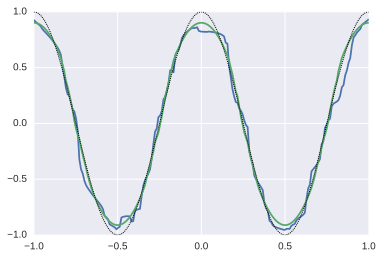

In [192]:
import nengo.solvers

decoders = nengo.solvers.LstsqL2()(activities_post_xs, xs)[0]

output = activities_post_ys @ decoders
output_ref = activities_post_ys_tar @ decoders

fig, ax = plt.subplots()
ax.plot(xs, output)
ax.plot(xs, output_ref)
ax.plot(xs, ys, color="black", linewidth=1, linestyle=(0, (1, 1)));